## How to select data from IceSat-2 tracks that are close to perpendicular to and within a given distance to the GL 

In [29]:
#Imports 
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sliderule import sliderule, icesat2, earthdata, h5
from shapely import wkt
from shapely.geometry import Point, LineString, shape
from scipy.spatial.distance import cdist
import itertools


from ROIhelpertools import triangle_maximum_angle, find_closest_point, find_angle

# Fancier plotting tools (we might need this later?)
#from cartopy import crs
#import geoviews as gv
#import geoviews.feature as gf
#from geoviews import dim, opts
#import geoviews.tile_sources as gts
#from bokeh.models import HoverTool
#gv.extension('bokeh')

### 1. Initialise SlideRule
 
For this project we will be using SlideRule to obtain IceSat-2 data from tracks that are perpendicular to the GL due to its high level of customization. Using SlideRule we are able to input a polygon of the predefined ROI and obtain data from within that region 

In [3]:
# Initialize SlideRule
icesat2.init("slideruleearth.io")
earthdata.set_max_resources(2000) # To get around an external speedbumb inside SlideRule. 

### 2. What do we need to select IceSat-2 tracks that are close to perpendicular to the Grounding line? 
* Polygon of GL 
* Polygon of buffer around GL (ROI) 
* ICESat-2 data


In [16]:
# Read in Grounding line(GL) file and Polygon of 120m buffer around GL
GL = gpd.read_file('Kamb_GL_short_line.geojson')
GL = GL.to_crs('EPSG:3031') # # reproject to a more suitable reference frame; Antarctic Polar Stereographic 

# Load in buffers of two different sizes as geopandas dataFrame: 
buffer120m = gpd.read_file('Kamb_GL_buffer120m_short.geojson') # 120 m buffer used to create a smaller dataset to compute the angles between GL line and track
buffer5km = gpd.read_file('Kamb_GL_buffer5km_short.geojson') # 5 km buffer defining the ROI. 
buffer120m = buffer120m.to_crs('EPSG:3031') # Reproject 120 m buffer to a more suitable reference frame.  
# 5 km Buffer as a SlideRule region:  
buffer5km_SR = sliderule.toregion('Kamb_GL_buffer5km_short.geojson')["poly"] 

In [17]:
# Define parameters for SlideRule: 
parms = {
    "poly": buffer5km_SR,
    "srt": 3,
    #"cnf": icesat2.CNF_SURFACE_HIGH,
    #"ats": 5.0,
    "len": 40.0,
    "res": 20.0,
    "maxi": 5,
    "t0": '2019-03-29T00:00:00Z'
}

# Calculated ATL06 dataframe from SlideRule: 
is2_df = icesat2.atl06p(parms, "nsidc-s3")

# Reproject to a more suitable reference frame; Antarctic Polar Stereographic 
is2_df = is2_df.to_crs('EPSG:3031')

# Compute a smaller dataset so it's easier to work with: 
is2_small_df = is2_df.clip(buffer120m)

<AxesSubplot: title={'center': 'IceSat-2 data from SlideRule'}>

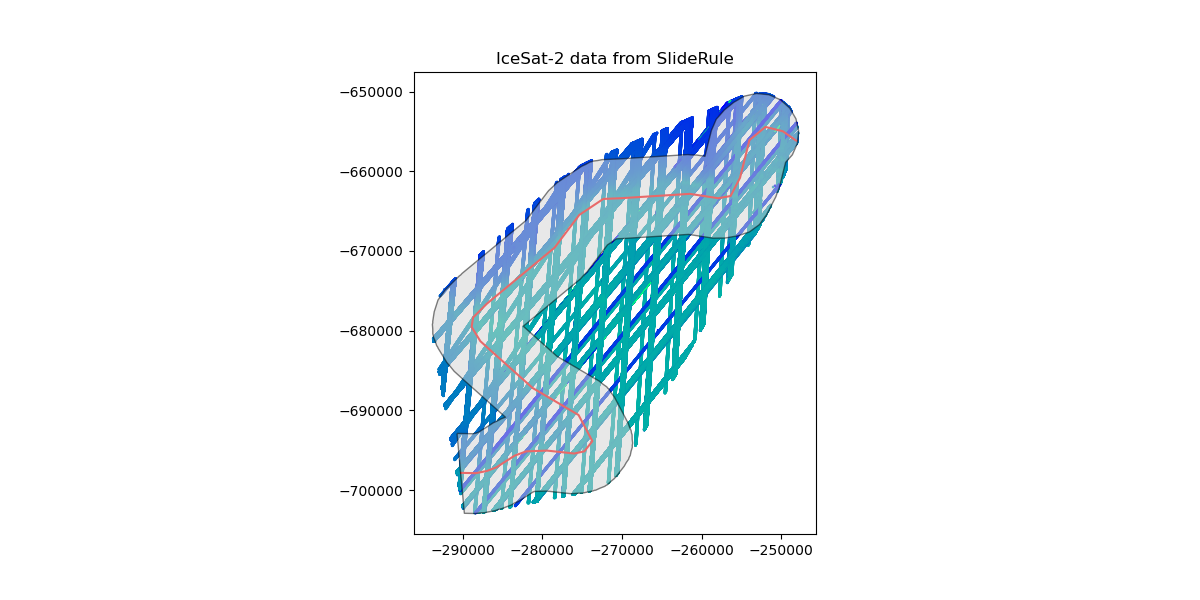

In [28]:
# Plot the output of SlideRule together with GL and buffer: 
%matplotlib widget

# Create Plot
fig,ax1 = plt.subplots(1, figsize=(12, 6))

# Plot SlideRule Ground Tracks
ax1.set_title("IceSat-2 data from SlideRule")
ROI = is2_df.plot(ax=ax1, column=is2_df["h_mean"], s=1.0, zorder=3, cmap='winter_r', vmin=-20, vmax=90)
GL.plot(ax=ax1, color='r', zorder = 100)
buffer5km.to_crs('EPSG:3031').plot(ax=ax1, edgecolor='k', facecolor="lightgrey", alpha = 0.5, zorder = 100)

## 3. Select only tracks that are close to perpendicular to the GL

In [20]:
ids = 1 #Intersection id
intersect_id = pd.DataFrame(columns = ['id','rgt', 'spot','x','y', 'angle']) # DataFrame with all intersections. 
accepted_is2 = pd.DataFrame(columns = is2_df.columns.tolist()+['dti']) # DataFrame with data 
angle_threshold = 10 # Threshold for acceptable range of angel between IS2 and GL, eg. 10 means the angle has to lie between 80 and 100 degrees. 

for rgt, spot in itertools.product(is2_small_df.rgt.unique(), is2_small_df.spot.unique()): # Iterate through rtacks and spots
    
    # Subset data to only include the given track and beam. For testing the angle we only look at data from cycle 3: 
    is2_df_subset = is2_small_df[(is2_small_df['rgt']==rgt) & (is2_small_df['spot']==spot) & (is2_small_df['cycle']==3)]
    
    if np.size(is2_df_subset, axis = 0) >= 2: # more than two datapoints in the subset.  
        
        # Finds the angle between points in the subset and the GL: 
        x0,y0, max_angle = find_angle(is2_df_subset.geometry, GL)
        
        if (max_angle >= (90 - angle_threshold)) and (max_angle <= (90 + angle_threshold)): # the angle bewteen the data and GL is close to perpendicular to the GL
            
            # Append intersection infomation to dataframe: 
            intersect_id.loc[len(intersect_id.index)]=[ids,rgt, spot, x0,y0, max_angle]
            ids+=1 # Change intersection id 
            
            # Subset all data from that given track and beam: 
            subset_all_data = is2_df[(is2_df['rgt']==rgt) & (is2_df['spot']==spot)]
            
            # Compute the distance to the intersection point for points in the new subset: 
            is2_subset_points = np.column_stack([np.array(subset_all_data.geometry.x), np.array(subset_all_data.geometry.y)])
            subset_all_data['dti'] = cdist([(x0, y0)], is2_subset_points,  metric = 'euclidean')[0]
            
            # Select only points within 5 km of the GL intersection:  
            accepted_is2 = accepted_is2.append(subset_all_data[subset_all_data['dti'] <= 5000])

# Convert to a GeoDataFrame so it's possible to plot: 
accepted_is2 = gpd.GeoDataFrame(accepted_is2, geometry='geometry', crs="EPSG:3031")
accepted_is2.head()

,dh_fit_dy,cycle,distance,w_surface_window_final,rgt,pflags,n_fit_photons,spot,gt,dh_fit_dx,segment_id,h_mean,rms_misfit,h_sigma,geometry,dti
2019-06-13 01:27:30.549297408,0.0,3,2.941492e+07,3.0,1157,0,190,3,30,-0.025306,1469702,26.399856,0.451399,0.032749,POINT (-251415.892 -659931.965),4982.201634
2019-06-13 01:27:30.552111104,0.0,3,2.941494e+07,3.0,1157,0,187,3,30,0.005429,1469703,26.161468,0.414392,0.030373,POINT (-251403.608 -659916.927),4962.784022
2019-06-13 01:27:30.554923520,0.0,3,2.941496e+07,3.0,1157,0,190,3,30,0.030026,1469704,26.498952,0.428468,0.031089,POINT (-251391.316 -659901.895),4943.366411
2019-06-13 01:27:30.557736192,0.0,3,2.941498e+07,3.0,1157,0,196,3,30,0.031820,1469705,27.132494,0.462794,0.033059,POINT (-251379.019 -659886.867),4923.948804
2019-06-13 01:27:30.560547072,0.0,3,2.941500e+07,3.0,1157,0,205,3,30,0.054064,1469706,28.018777,0.511922,0.035825,POINT (-251366.722 -659871.840),4904.531198


<AxesSubplot: title={'center': 'IceSat-2 data within 5 km and 80-100${\\degree}$ to the GL'}>

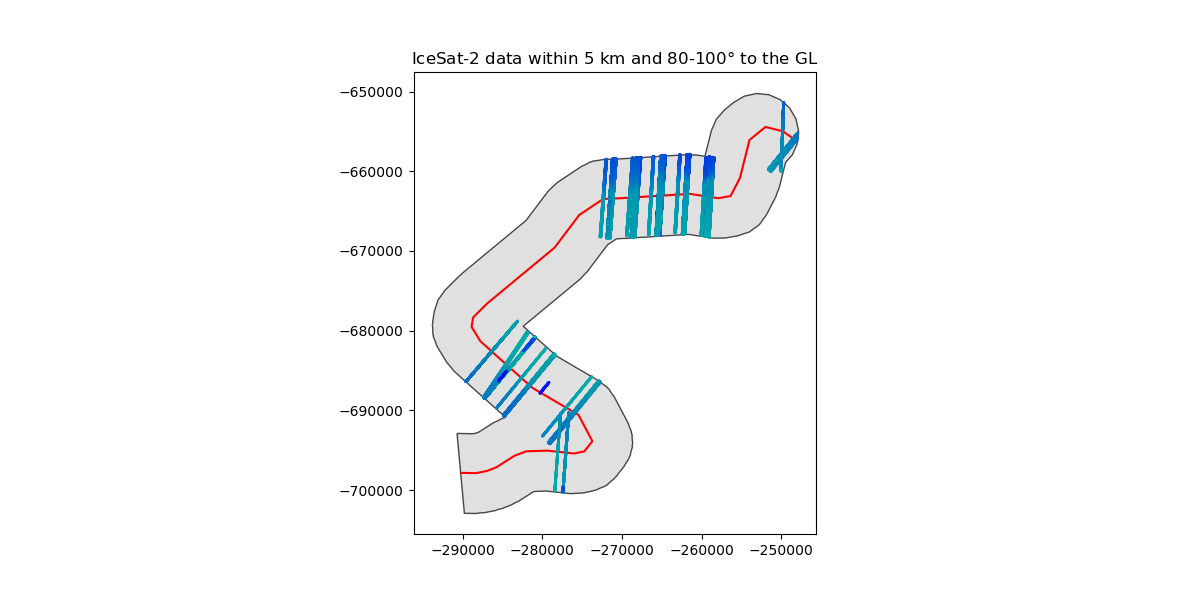

In [31]:
# Plot of the selected tracks and beams: 
fig,ax1 = plt.subplots(1, figsize=(12, 6))

# Plot SlideRule Ground Tracks
ax1.set_title(r"IceSat-2 data within 5 km and 80-100${\degree}$ to the GL")
ROI = accepted_is2.plot(ax=ax1, column=accepted_is2["h_mean"], s=1.0, zorder=3, cmap='winter_r', vmin=-20, vmax=90)
GL.plot(ax=ax1, color='r')
selected = subset_all_data[subset_all_data['dti'] <= 5000]
buffer5km.to_crs('EPSG:3031').plot(ax=ax1, edgecolor='k', facecolor="lightgrey", alpha = 0.7)

### Plotting together with REMA hillshade: 

(-712880.1121299583, -640180.1108502339)

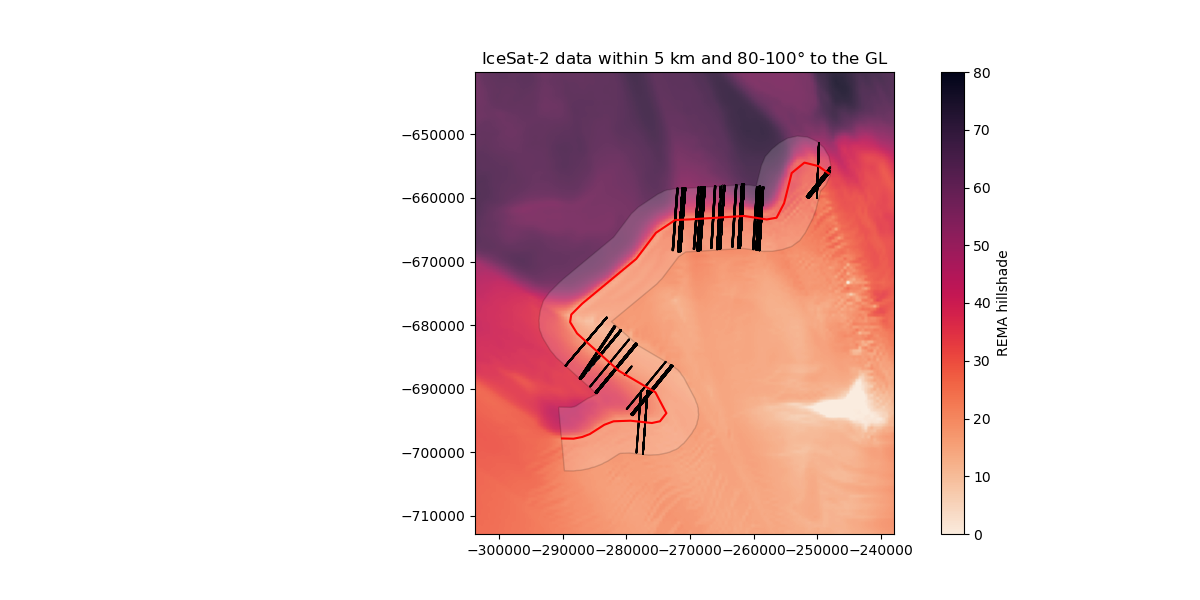

In [174]:
import rasterio as rio
from rasterio import plot as rioplot
from rasterio import warp
import seaborn as sns

REMAimage = rio.open('REMA.tiff')
buffer_extent = buffer5km.to_crs('EPSG:3031').geometry.bounds.iloc[0]
xlim = ([buffer_extent[0]-10000,  buffer_extent[2]+10000])
ylim = ([buffer_extent[1]-10000,  buffer_extent[3]+10000])

fig, ax = plt.subplots(figsize=(12, 6))
im = rioplot.show(REMAimage, ax=ax, vmin = 0, vmax = 80, cmap=sns.color_palette("rocket_r", as_cmap=True), alpha = 0.9);
GL.plot(ax=ax, color='r')
buffer5km.to_crs('EPSG:3031').plot(ax=ax, edgecolor='k', facecolor='white', alpha = 0.15)
ax.set_title(r"IceSat-2 data within 5 km and 80-100${\degree}$ to the GL")
ROI = accepted_is2.plot(ax=ax, column=accepted_is2["h_mean"], s=0.050, zorder=1, cmap='Greys', vmin=-20, vmax=0)
# add colorbar and change extents:
image_hidden = ax.imshow(REMAimage.read()[0],vmin = 0, vmax = 80, cmap=sns.color_palette("rocket_r", as_cmap=True) )
plt.colorbar(image_hidden, ax=ax, label = 'REMA hillshade')
ax.set_xlim(xlim)
ax.set_ylim(ylim)